# BKT Processing

This notebook processed all data files (15 in total) and generate a CSV result file for each one. To understand how the processing works in detail, please refer to the `analysis/try_bkt.ipynb` notebook.

In [1]:
import warnings
import numpy as np

# Suppress RuntimeWarnings
warnings.filterwarnings("ignore", module="pyBKT.fit.EM_fit")

# Additionally, suppress NumPy warnings
np.seterr(all="ignore")  # This will suppress warnings from NumPy operations

import pandas as pd
import re
import rich
import os

from pyBKT.models import Model


def _extract_chapter(path: str) -> str:
    """
    Extract the chapter name from the path
    """
    # The path is in the format of responses_assessment_level2_1.1.csv
    # We want to extract the chapter number from the file name, i.e. 1.1 in this case
    chapter_pattern = re.compile(r".*responses_assessment_level2_(\d+\.\d+)\.csv")

    # Find column from data.columns that match the above pattern and extract out the chapter
    match = chapter_pattern.match(path)
    chapter = match.group(1)
    return chapter


def process_data(path: str, output_folder: str) -> dict[str, float]:
    """
    Process the data from the file specified by the path.
    Return the coefs learned from the model as a dict.
    """

    data = pd.read_csv(path, index_col=0, low_memory=False)
    chapter = _extract_chapter(path)

    rich.print(f"[yellow bold]Processing chapter: [/yellow bold]{chapter}")

    if len(data) == 0:
        rich.print("[red bold]No data found, skipped[/red bold]")
        return

    # Define the columns we're interested in
    points_earned_col = "points_earned"
    submitted_col = "dt_submitted"
    student_id_col = "student_id"
    item_id_col = "item_id"
    type_col = "item_type"

    # Run some transformations to get the data into the correct format
    # Drop nan values in the points_earned column
    data = data.dropna(subset=[points_earned_col])

    # Ensure the dt_submitted column is in datetime format
    data[submitted_col] = pd.to_datetime(data[submitted_col])

    # drop duplicate rows
    data = data.drop_duplicates()

    # Sort the data by student, item_id and submission time to create order_id
    data = data.sort_values(by=[student_id_col, item_id_col, submitted_col])

    # Process code submissions differently from learnosity
    def process_student_submissions(group):
        # Do not process if the question type is not `code`
        if group[type_col].iloc[0] != "code":
            return group

        # Always keep first submission
        result = group.iloc[[0]]

        # If first submission was incorrect and there exists a correct submission
        if (
            group[points_earned_col].iloc[0] == 0
            and (group[points_earned_col] > 0).any()
        ):
            # Find first correct submission
            first_correct = group[group[points_earned_col] > 0].iloc[0]
            result = pd.concat([result, first_correct.to_frame().T])

        return result

    # Apply the processing logic to each student-question combination
    processed_data = data.groupby(
        [student_id_col, item_id_col], group_keys=False
    ).apply(process_student_submissions)

    # Now sort by student and submission time to create final order_id
    processed_data = processed_data.sort_values(by=[student_id_col, submitted_col])

    # Create order_id (sequence number of observations per student)
    processed_data["order_id"] = processed_data.groupby(student_id_col).cumcount() + 1

    # Rename columns to match pyBKT expected format
    bkt_data = processed_data.rename(
        columns={
            student_id_col: "user_id",
            points_earned_col: "correct",
        }
    )

    # Assign a skill name (you can change this if you're tracking multiple skills)
    bkt_data["skill_name"] = (
        0  # If you're tracking only one skill, this can be constant
    )

    bkt_data = bkt_data.reset_index()

    # Drop unnecessary columns
    bkt_data = bkt_data[["user_id", "order_id", "correct", "skill_name"]]

    if len(bkt_data) == 0:
        rich.print("[red bold]No BKT data built, skipped[/red bold]")
        return

    # Fit the model
    model = Model(seed=42, num_fits=1)

    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=RuntimeWarning)

        model.fit(data=bkt_data)

        # Generate predictions for each attempt
        predictions = model.predict(data=bkt_data)

    # Get the final predictions after all attempts for each student
    final_predictions = predictions.groupby("user_id").last()[
        ["correct_predictions", "state_predictions"]
    ]

    # Rename the aggregated columns
    final_predictions = final_predictions.rename(
        columns={
            "state_predictions": "final_state_predictions",
            "correct_predictions": "final_correct_predictions",
        }
    )

    # Create the folder if it doesn't exist using python
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    final_predictions.to_csv(f"{output_folder}/predictions_{chapter}.csv")

    # Process the coefficients
    coef = model.coef_["0"]
    return {
        "chapter": chapter,
        "prior": float(coef["prior"]),
        "learns": float(coef["learns"][0]),
        "guesses": float(coef["guesses"][0]),
        "slips": float(coef["slips"][0]),
    }

In [2]:
import os
import glob

# Differentiate different runs on the same data
SUFFIX = "simplify_coding_attempts"

DATA_ROOT = "../data/csv_oct15_24"
OUTPUT_ROOT = "./output/" + DATA_ROOT.split("/")[-1] + "_" + SUFFIX
COEF_OUTPUT = OUTPUT_ROOT + "/coefs.csv"

csv_files = glob.glob(os.path.join(DATA_ROOT, "*.csv"))

In [3]:
all_coefs: list[dict[str, float]] = []

for csv_file in csv_files:
    coefs = process_data(csv_file, OUTPUT_ROOT)
    all_coefs.append(coefs)
    with open(COEF_OUTPUT, "w") as f:
        pd.DataFrame(all_coefs).to_csv(f, index=False)

rich.print("[green bold]Done![/green bold]")

Processing chapter: 3.2

/var/folders/3h/16r_n_t90kg2dd10vc578fjh0000gn/T/ipykernel_88677/173134254.py:88: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  processed_data = data.groupby(


Processing chapter: 3.3

/var/folders/3h/16r_n_t90kg2dd10vc578fjh0000gn/T/ipykernel_88677/173134254.py:88: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  processed_data = data.groupby(


Processing chapter: 1.1

/var/folders/3h/16r_n_t90kg2dd10vc578fjh0000gn/T/ipykernel_88677/173134254.py:88: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  processed_data = data.groupby(


Processing chapter: 1.3

/var/folders/3h/16r_n_t90kg2dd10vc578fjh0000gn/T/ipykernel_88677/173134254.py:88: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  processed_data = data.groupby(


Processing chapter: 3.1

/var/folders/3h/16r_n_t90kg2dd10vc578fjh0000gn/T/ipykernel_88677/173134254.py:88: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  processed_data = data.groupby(
/var/folders/3h/16r_n_t90kg2dd10vc578fjh0000gn/T/ipykernel_88677/173134254.py:88: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  processed_data = data.groupby(


Processing chapter: 1.2

/var/folders/3h/16r_n_t90kg2dd10vc578fjh0000gn/T/ipykernel_88677/173134254.py:88: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  processed_data = data.groupby(


Processing chapter: 3.4

/var/folders/3h/16r_n_t90kg2dd10vc578fjh0000gn/T/ipykernel_88677/173134254.py:88: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  processed_data = data.groupby(


Processing chapter: 3.5

/var/folders/3h/16r_n_t90kg2dd10vc578fjh0000gn/T/ipykernel_88677/173134254.py:88: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  processed_data = data.groupby(


Processing chapter: 3.6

/var/folders/3h/16r_n_t90kg2dd10vc578fjh0000gn/T/ipykernel_88677/173134254.py:88: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  processed_data = data.groupby(


Processing chapter: 2.1

/var/folders/3h/16r_n_t90kg2dd10vc578fjh0000gn/T/ipykernel_88677/173134254.py:88: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  processed_data = data.groupby(


Processing chapter: 2.2

/var/folders/3h/16r_n_t90kg2dd10vc578fjh0000gn/T/ipykernel_88677/173134254.py:88: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  processed_data = data.groupby(


Processing chapter: 2.3

/var/folders/3h/16r_n_t90kg2dd10vc578fjh0000gn/T/ipykernel_88677/173134254.py:88: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  processed_data = data.groupby(


Processing chapter: 4.1

/var/folders/3h/16r_n_t90kg2dd10vc578fjh0000gn/T/ipykernel_88677/173134254.py:88: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  processed_data = data.groupby(


Processing chapter: 4.2

/var/folders/3h/16r_n_t90kg2dd10vc578fjh0000gn/T/ipykernel_88677/173134254.py:88: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  processed_data = data.groupby(


Processing chapter: 4.3

/var/folders/3h/16r_n_t90kg2dd10vc578fjh0000gn/T/ipykernel_88677/173134254.py:88: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  processed_data = data.groupby(
/var/folders/3h/16r_n_t90kg2dd10vc578fjh0000gn/T/ipykernel_88677/173134254.py:88: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  processed_data = data.groupby(


Done!

# Plot

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

from typing import Literal

%config InlineBackend.figure_format = 'retina'

sns.set_theme("notebook")

def plot_histograms(column: Literal["final_state_predictions", "final_correct_predictions"]):
    """
    Plot the histogram of the final state predictions or final correct predictions.
    For each output_dfs, plot a histogram as a subplot.
    """

    output_files = sorted(glob.glob(f"{OUTPUT_ROOT}/*.csv"))
    output_files = [f for f in output_files if "predictions" in f]
    output_dfs = [pd.read_csv(f) for f in output_files] 

    # Setup subplots, at most 4 subplots per row
    num_plots = len(output_dfs)
    num_rows = (num_plots + 3) // 4
    num_cols = min(num_plots, 4)
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(6*num_cols, 4*num_rows))

    for i, (f, df) in enumerate(zip(output_files, output_dfs)):
        row = i // 4
        col = i % 4
        ax = axs[row, col] if num_rows > 1 else axs[col]
        sns.histplot(df[column], ax=ax, bins=20)
        chapter = re.search(r"predictions_(\d+\.\d+).csv", f).group(1)
        ax.set_title(f"Chapter {chapter}")
    
    
    fig.suptitle(f"Histogram of {column}", fontsize=18)
    fig.tight_layout()

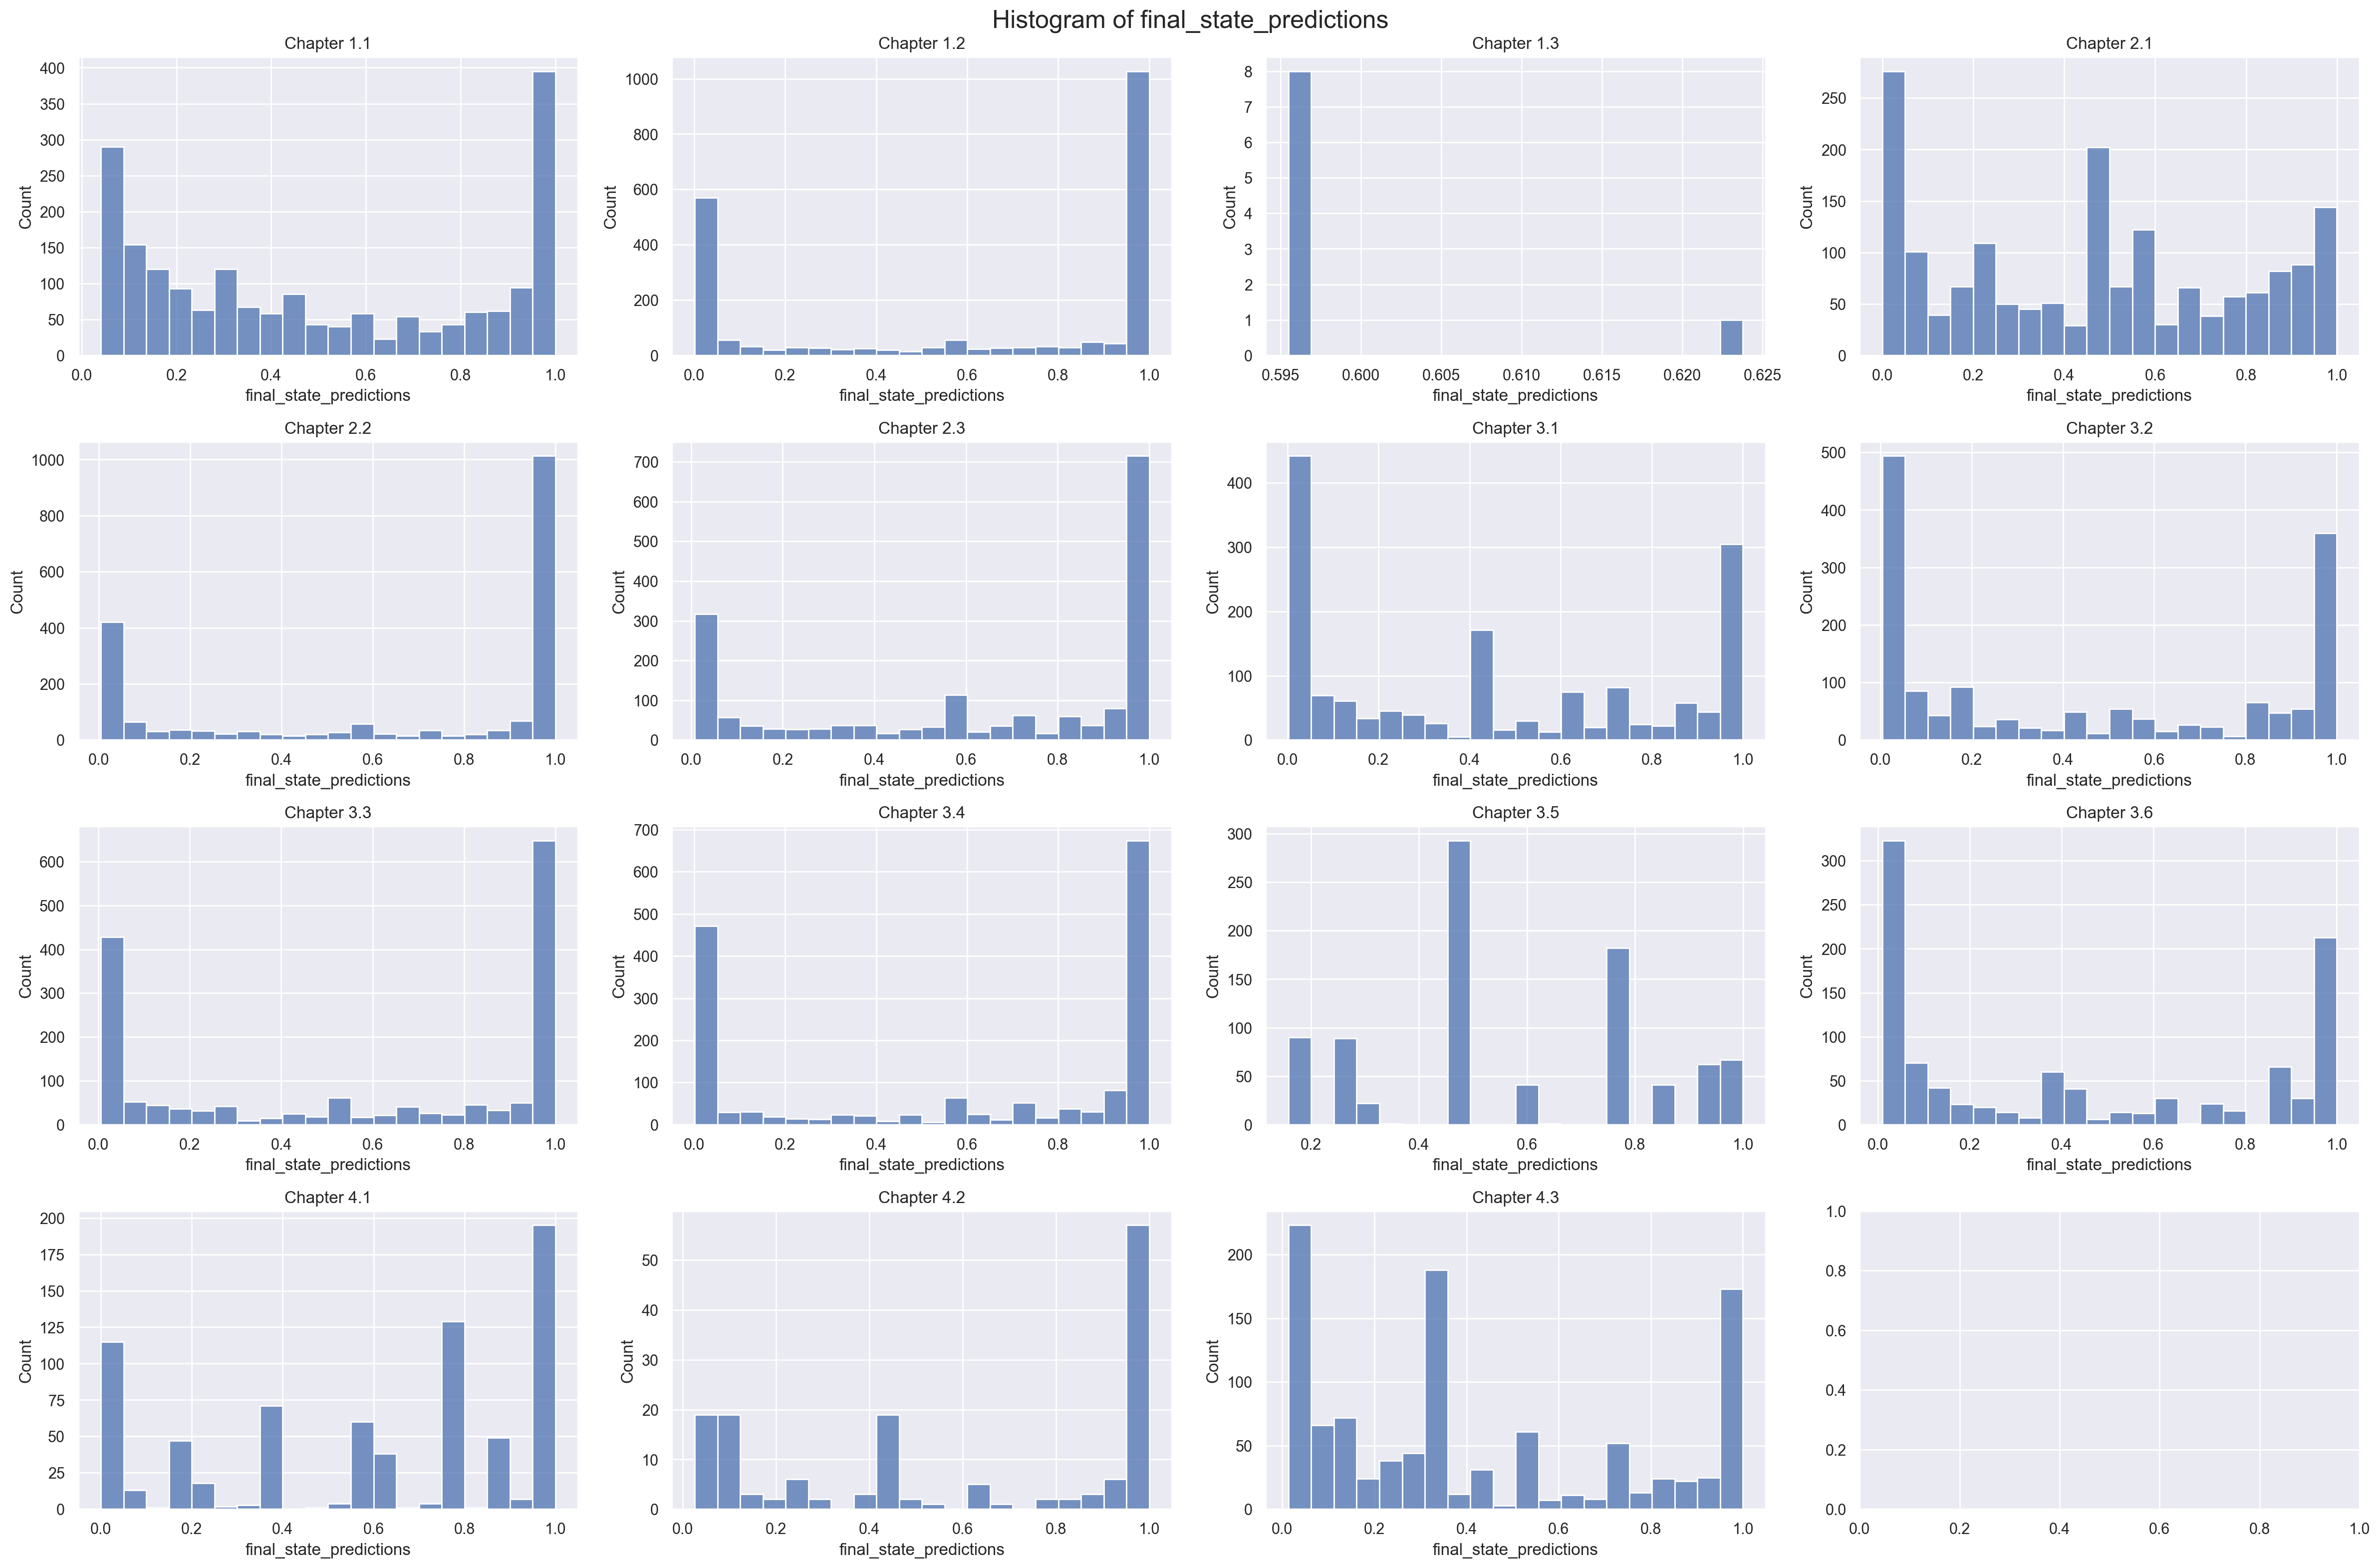

In [5]:
plot_histograms("final_state_predictions")

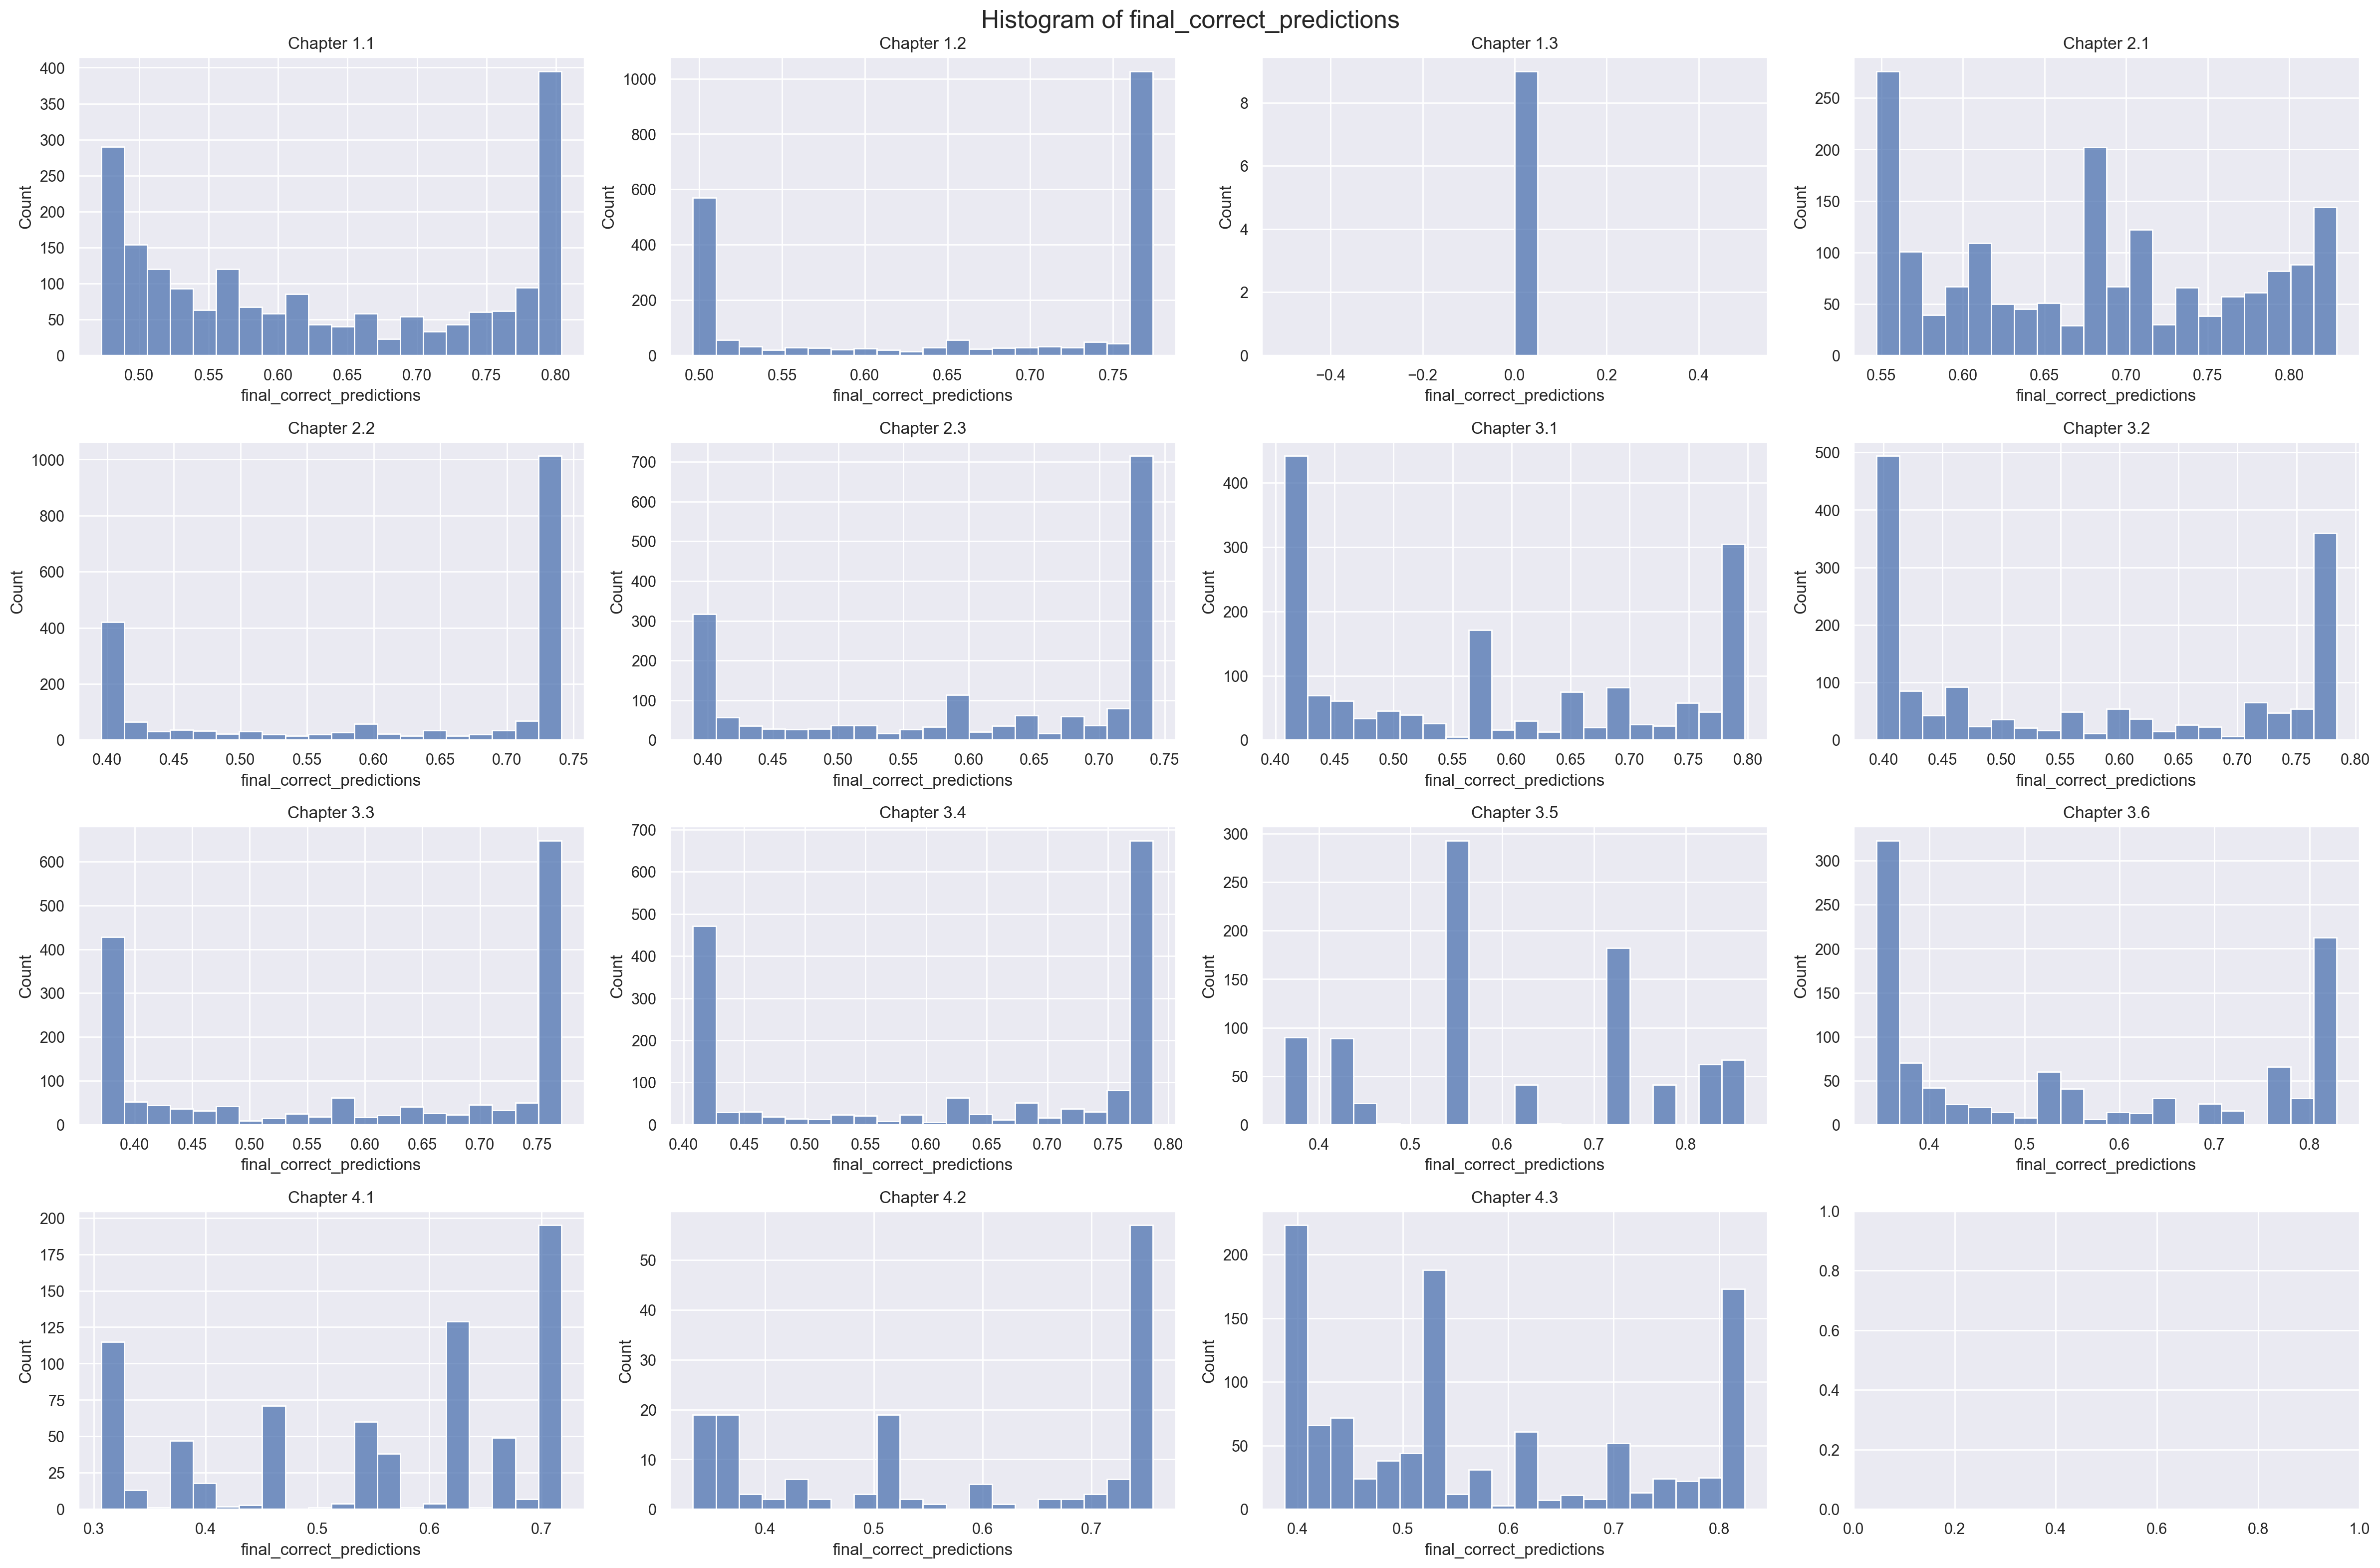

In [6]:
plot_histograms("final_correct_predictions")